# 4. Conditional GANs [BONUS]

A simple way to improve training performance and obtain control of the generation is to provide extra information into the Generator and the Discriminator, known as **Conditional GANs**. In this case, we will provide the class label (digit number of MNIST) into both the generator and the discriminator. This will help both of the networks.

## 4.1 Conditional Generator and Discriminator

Complete the ConditionalDiscriminator and ConditionalGenerator classes using your GAN building blocks (`get_upsampling_block` and `get_downsampling_block` functions).


### 4.1.1 Generator

In [55]:
# GENERATOR

'''
The conditional generator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the generator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized

'''

class ConditionalGenerator(nn.Module):
    def __init__(self, nz, nc, ngf, nchannels=1):
        super().__init__()

        self.upscaling_z = get_upscaling_block(nz, ngf*8, 4, 1, 0)
        self.upscaling_c = get_upscaling_block(nc, ngf*8, 4, 1, 0)

        ######### CODE A REMPLIR ##############################################################               
        # Image generation after concatenation of z and c feature maps
        self.rest_model = nn.Sequential(
            get_upscaling_block(ngf*8*2, ngf*8, kernel=4, stride=2, padding=1),  
            get_upscaling_block(ngf*8, ngf*4, kernel=4, stride=2, padding=1),     
            get_upscaling_block(ngf*4, 1, kernel=4, stride=2, padding=1, last_layer=True),
        )
        #######################################################################################

    def forward(self, x, y):
        x = x.unsqueeze(2).unsqueeze(2)   # [n_batch, nz] -> [n_batch, nz, 1, 1]
        y = y.unsqueeze(2).unsqueeze(2)   # [n_batch, nc] -> [n_batch, nc, 1, 1]

        ######### CODE A REMPLIR ##############################################################
        z = self.upscaling_z(x)  # [n_batch, ngf*8, 4, 4]
        c = self.upscaling_c(y)  # [n_batch, ngf*8, 4, 4]

        # Concatenate z and c feature maps
        x = torch.cat([z, c], dim=1)  # [n_batch, ngf*8*2, 4, 4]
        #######################################################################################

        return self.rest_model(x)

### 4.1.2 Discriminator

In [ ]:
# Discriminator

'''
The conditional discriminator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the discriminator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized

'''

class ConditionalDiscriminator(nn.Module):
    def __init__(self, ndf, nc, nchannels=1):
        super().__init__()
        self.downscale_x = get_downscaling_block(nchannels, ndf*2, 4, 2, 1, use_batch_norm=False)
        self.downscale_y = get_downscaling_block(nc, ndf*2, 4, 2, 1, use_batch_norm=False)

        ######### CODE A REMPLIR ##############################################################               
        self.rest = nn.Sequential(
            get_downscaling_block(ngf*2*2, ngf*8, kernel=4, stride=2, padding=1),  
            get_downscaling_block(ngf*8, ngf*16, kernel=4, stride=2, padding=1),     
            get_downscaling_block(ngf*16, 1, kernel=4, stride=1, padding=0, is_last=True),
        )
        #######################################################################################
    

    def forward(self, x, y):

        ######### CODE A REMPLIR ##############################################################
        y = y.unsqueeze(2).unsqueeze(2) # [n_batch, nc] -> [n_batch, nc, 1, 1]
        y = y.expand(-1, -1, 32, 32)    # [n_batch, nc, 1, 1] -> [n_batch, nc, 32, 32]

        x = self.downscale_x(x)  # [n_batch, ngf*2, 4, 4]
        y = self.downscale_y(y)  # [n_batch, ngf*2, 4, 4]

        # Concatenate z and c feature maps
        x = torch.cat([x, y], dim=1)  # [n_batch, ngf*8*2, 4, 4]
        #######################################################################################

        return self.rest(x).squeeze(1).squeeze(1) # remove spatial dimensions

### 4.1.3 Sanity Checks

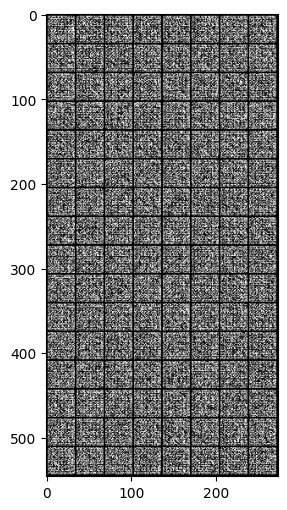

In [60]:
# CONDITIONAL GENERATOR SANITY CHECKING

z = torch.randn(batch_size, nz)
y = F.one_hot(real_labels).float()

cG = ConditionalGenerator(nz=nz, ngf=16, nc=10)
x_fake = cG(z, y)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

In [61]:
# Conditional Discriminator Sanity Checking

cD = ConditionalDiscriminator(ndf=32, nc=10, nchannels=1)
assert cD(real_batch, F.one_hot(real_labels).float()).shape == (real_batch.shape[0], 1)

## 4.2 Training

In [62]:
nz = 100
ndf = 32
ngf = 32
nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

nc= 10

netD = ConditionalDiscriminator(ndf, nc, nchannels=1).to(device)
netG = ConditionalGenerator(nz, nc, ngf).to(device)

netG.apply(weights_init)
netD.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))



it: 0; g_loss: 5.950719833374023; d_loss: 0.8738845586776733; avg_real_score: 0.885709285736084; avg_fake_score: 0.37093764543533325: : 0it [00:01, ?it/s]

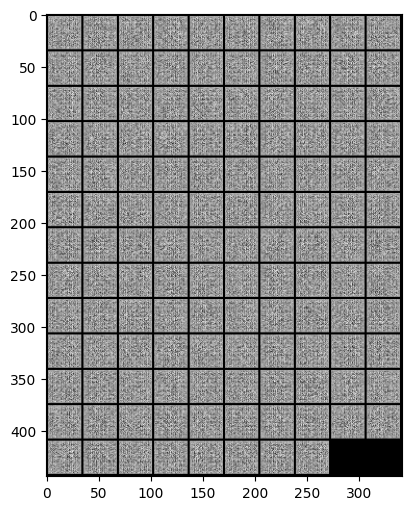

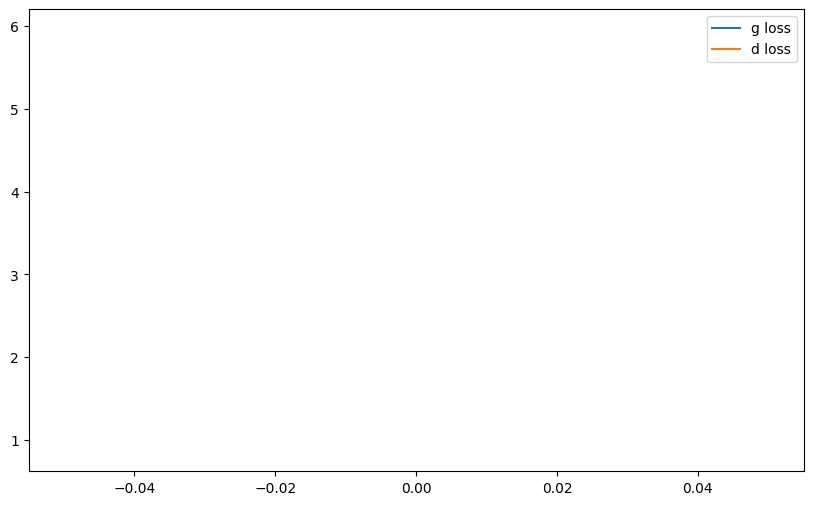

it: 200; g_loss: 2.6760048866271973; d_loss: 2.1894121170043945; avg_real_score: 0.4572659730911255; avg_fake_score: 0.6542854905128479: : 200it [03:20,  1.01it/s]  

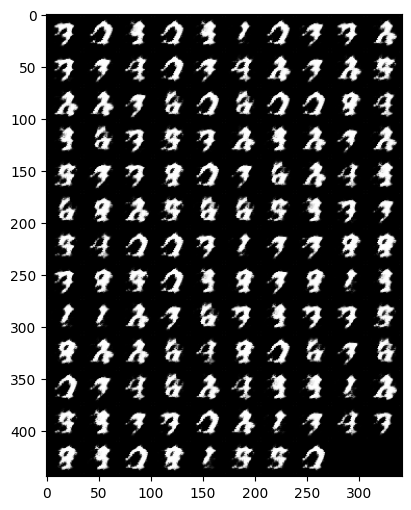

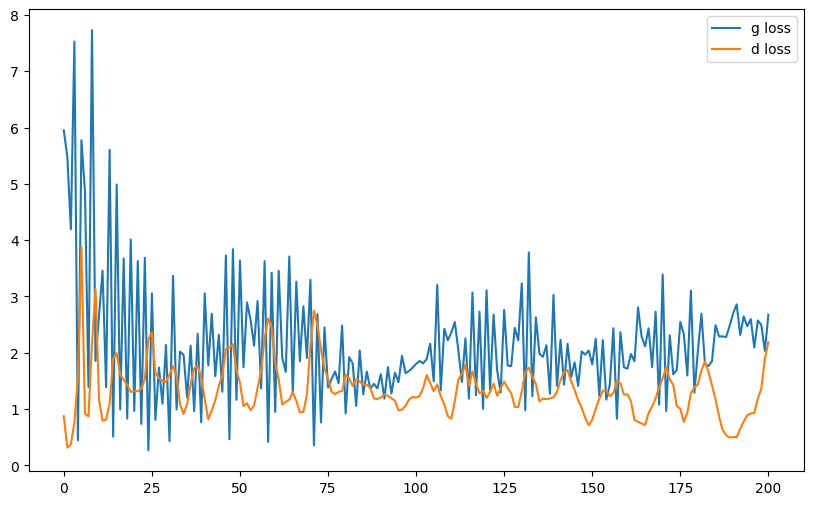

it: 400; g_loss: 1.6543996334075928; d_loss: 1.3939963579177856; avg_real_score: 0.539198100566864; avg_fake_score: 0.400566965341568: : 400it [06:39,  1.01it/s]    

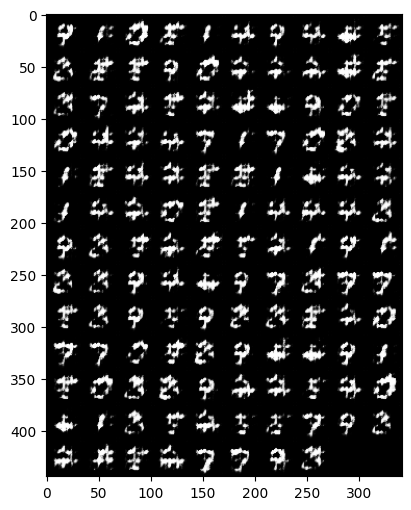

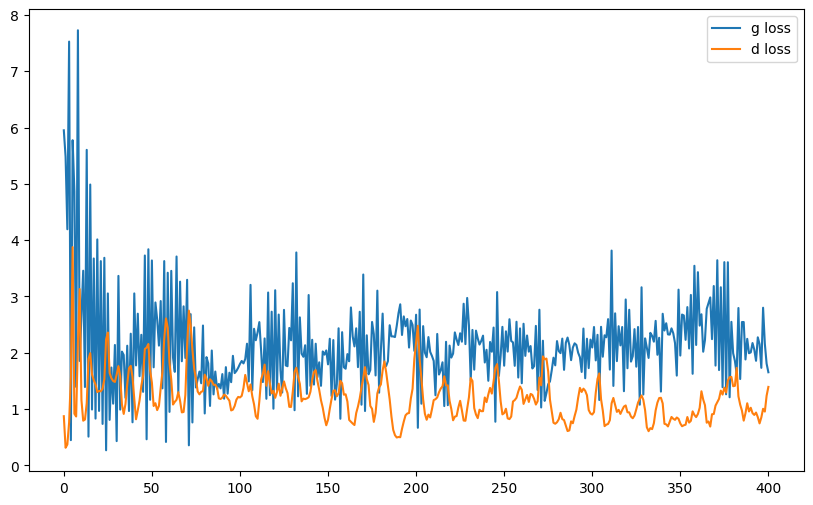

it: 468; g_loss: 1.9354805946350098; d_loss: 0.8220316767692566; avg_real_score: 0.7042497992515564; avg_fake_score: 0.3165860176086426: : 469it [07:47,  1.00it/s]  
it: 469; g_loss: 1.7694876194000244; d_loss: 0.850414514541626; avg_real_score: 0.6829487085342407; avg_fake_score: 0.307187557220459: : 0it [00:00, ?it/s]

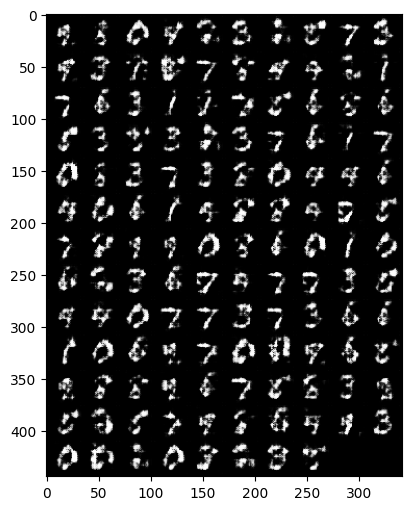

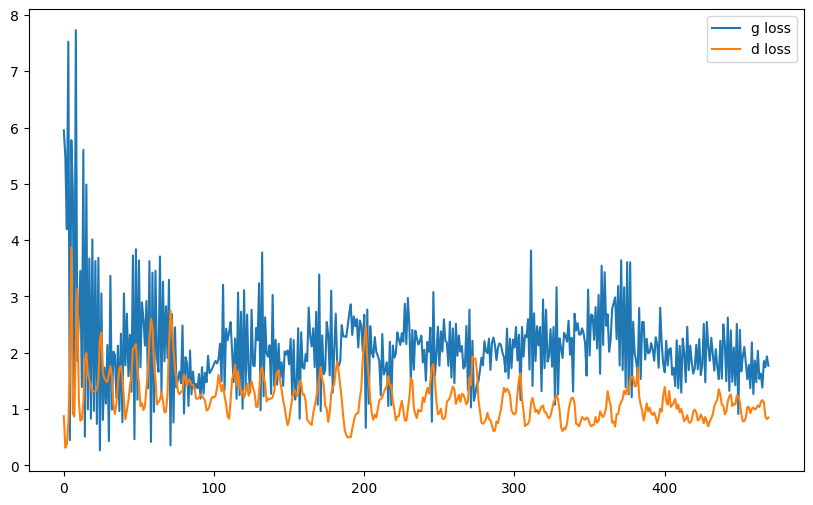

it: 669; g_loss: 0.8147874474525452; d_loss: 1.3922942876815796; avg_real_score: 0.44643351435661316; avg_fake_score: 0.3011018633842468: : 200it [03:21,  1.00it/s]

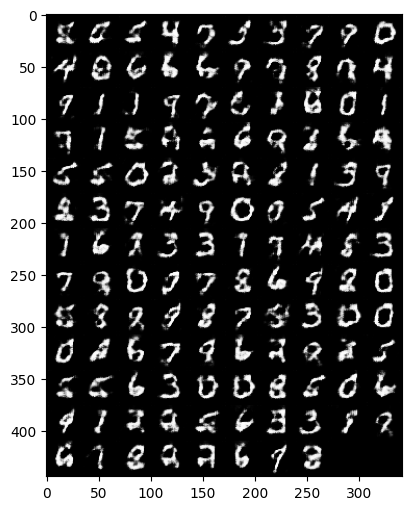

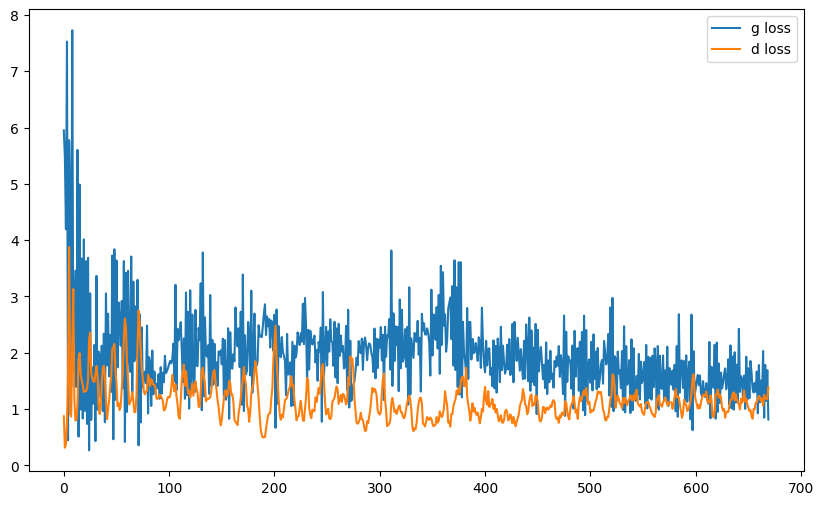

it: 869; g_loss: 1.0083813667297363; d_loss: 1.2294433116912842; avg_real_score: 0.5374671816825867; avg_fake_score: 0.3916410803794861: : 400it [06:40,  1.01it/s]  

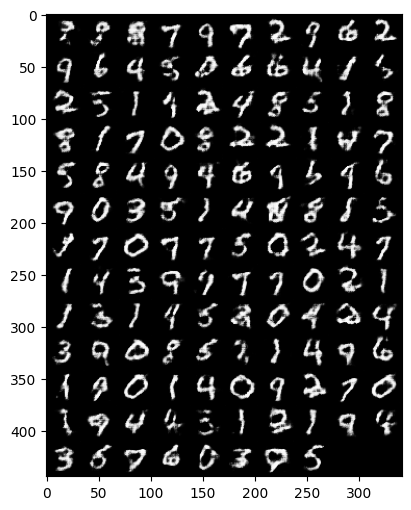

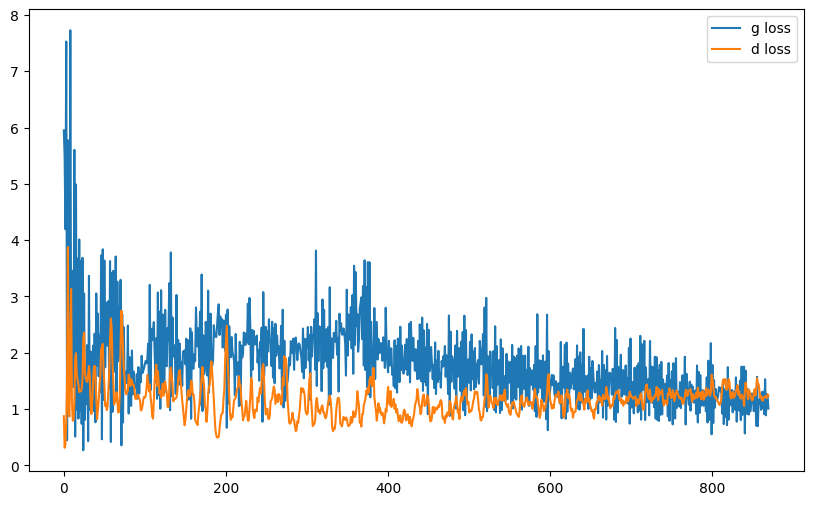

it: 937; g_loss: 1.2259454727172852; d_loss: 1.2248985767364502; avg_real_score: 0.58427494764328; avg_fake_score: 0.4525168836116791: : 469it [07:48,  1.00it/s]    
it: 938; g_loss: 1.0379009246826172; d_loss: 1.283674955368042; avg_real_score: 0.5420287847518921; avg_fake_score: 0.4320914149284363: : 0it [00:00, ?it/s]

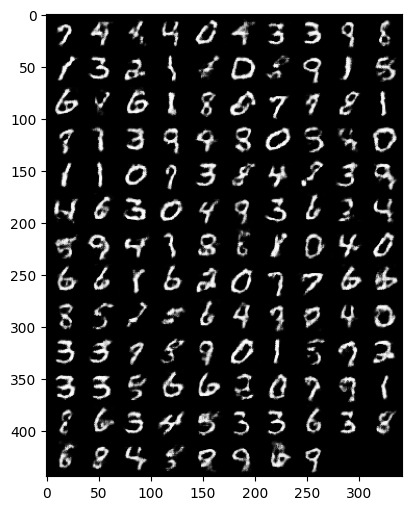

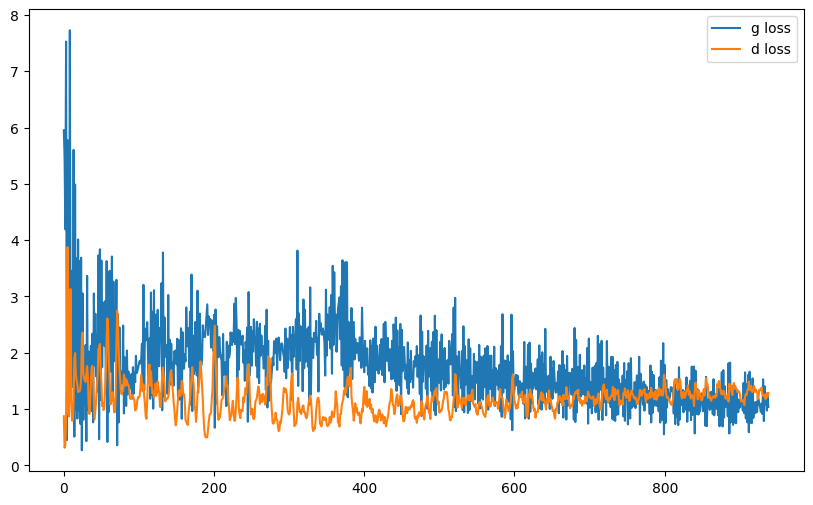

it: 1138; g_loss: 1.087724208831787; d_loss: 1.3509148359298706; avg_real_score: 0.49207043647766113; avg_fake_score: 0.418939471244812: : 200it [03:21,  1.00s/it]   

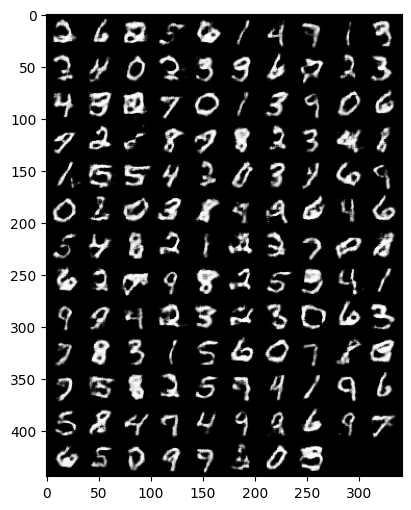

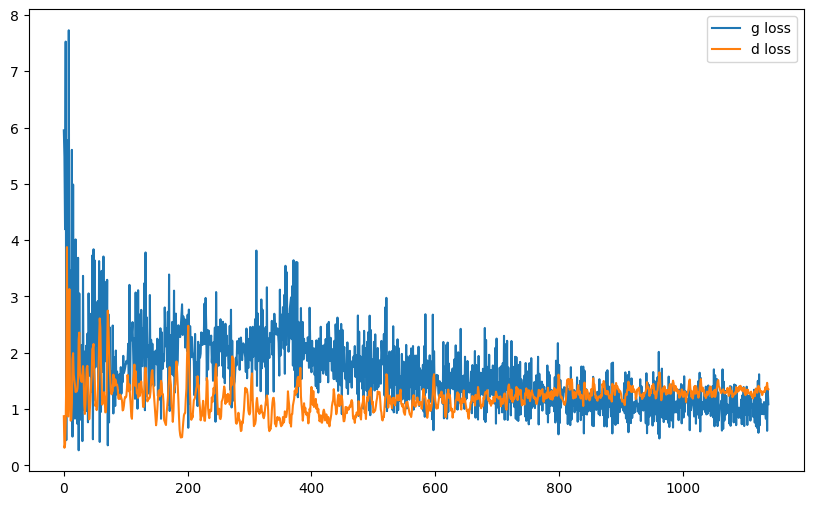

it: 1338; g_loss: 0.7757542133331299; d_loss: 1.328426718711853; avg_real_score: 0.4574056565761566; avg_fake_score: 0.37069571018218994: : 400it [06:43,  1.00it/s]   

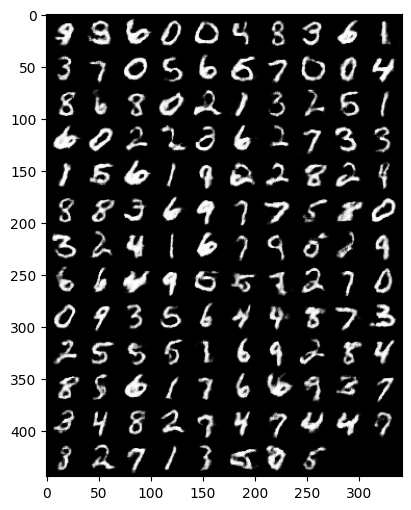

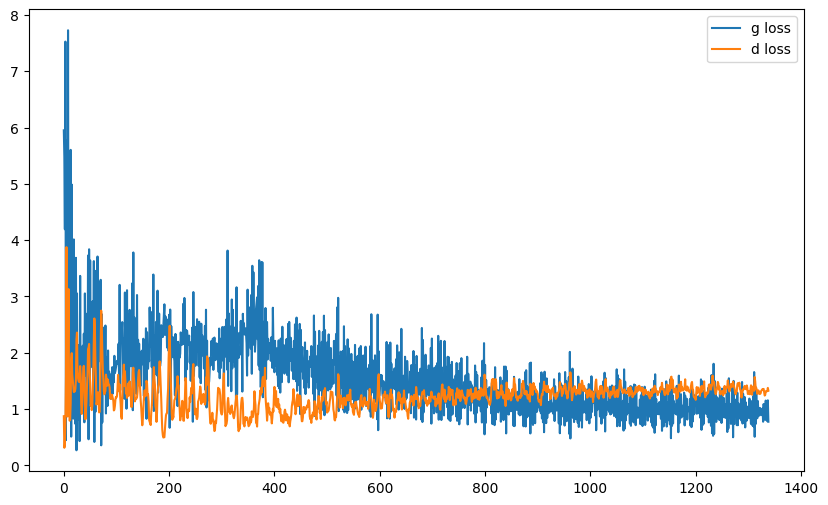

it: 1406; g_loss: 0.6539568901062012; d_loss: 1.3944602012634277; avg_real_score: 0.42105168104171753; avg_fake_score: 0.37454694509506226: : 469it [07:51,  1.01s/it]
it: 1407; g_loss: 1.1415283679962158; d_loss: 1.3668651580810547; avg_real_score: 0.6269882321357727; avg_fake_score: 0.5664999485015869: : 0it [00:01, ?it/s]

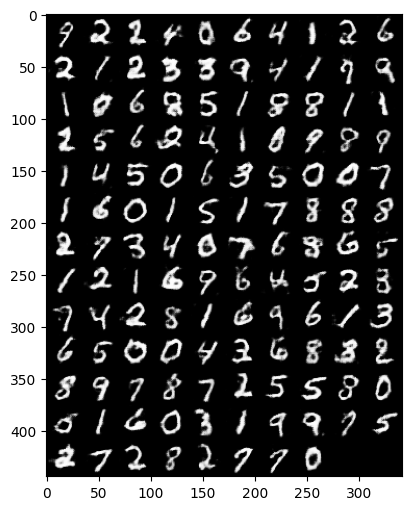

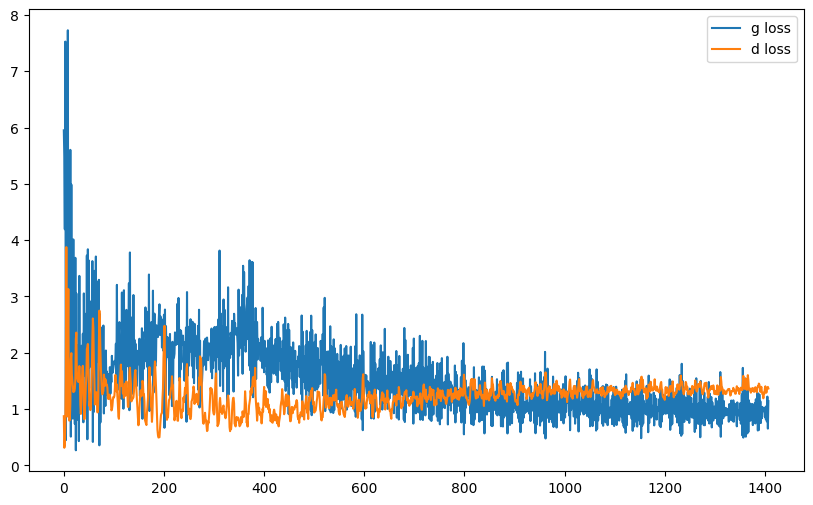

it: 1607; g_loss: 1.0156737565994263; d_loss: 1.3365960121154785; avg_real_score: 0.5512593984603882; avg_fake_score: 0.5002723932266235: : 200it [03:21,  1.00s/it]  

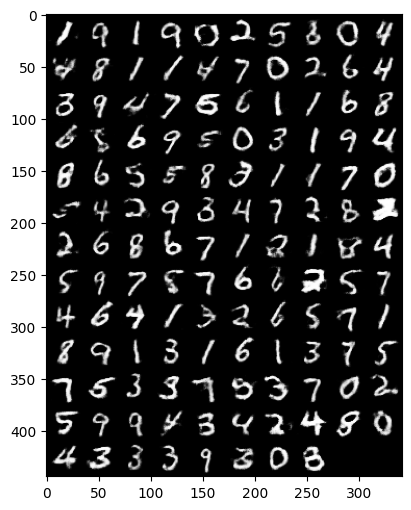

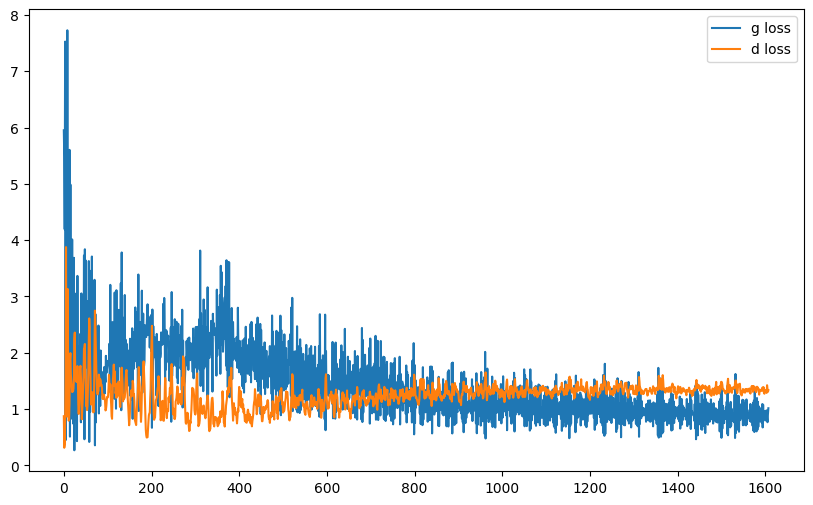

it: 1807; g_loss: 0.8176894783973694; d_loss: 1.4215048551559448; avg_real_score: 0.5152267813682556; avg_fake_score: 0.5039505958557129: : 400it [06:42,  1.00s/it]  

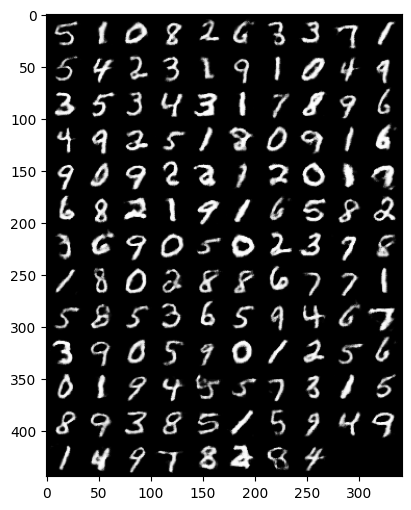

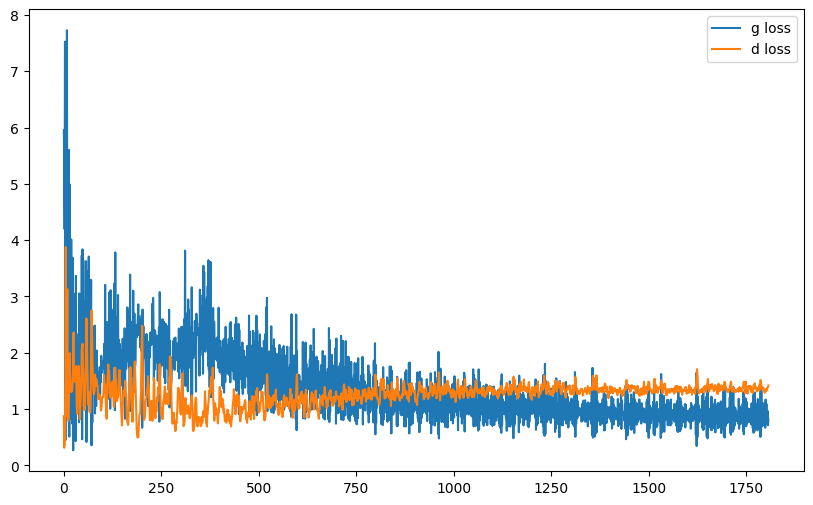

it: 1875; g_loss: 1.1058844327926636; d_loss: 1.3154594898223877; avg_real_score: 0.5523906946182251; avg_fake_score: 0.4910208582878113: : 469it [07:50,  1.00s/it]  
it: 1876; g_loss: 0.5374984741210938; d_loss: 1.343034029006958; avg_real_score: 0.43244877457618713; avg_fake_score: 0.36251673102378845: : 0it [00:01, ?it/s]

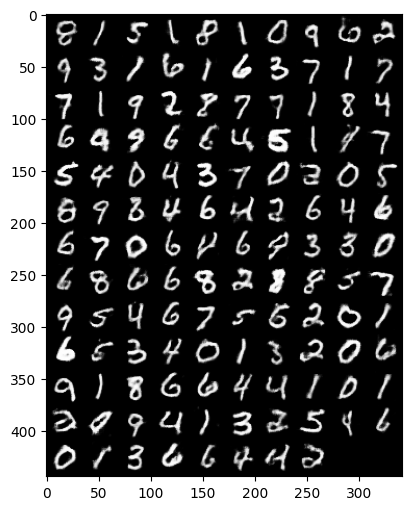

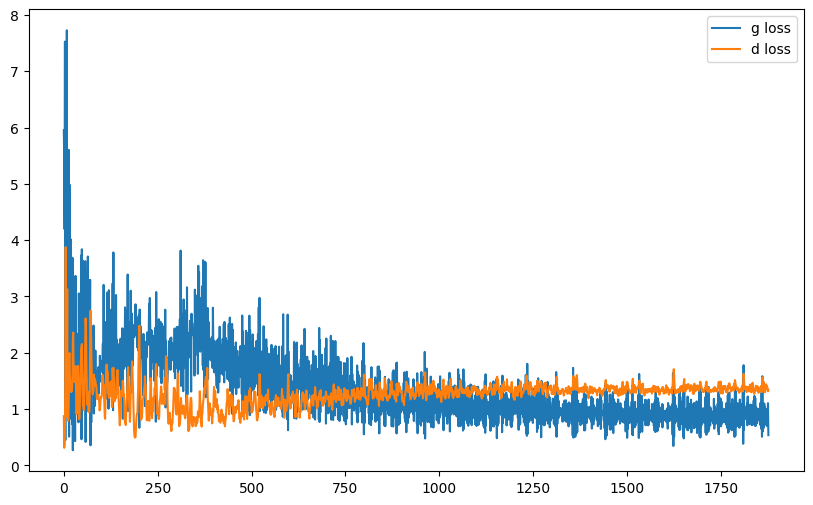

it: 2076; g_loss: 0.6495530009269714; d_loss: 1.3829874992370605; avg_real_score: 0.4511980414390564; avg_fake_score: 0.4226442575454712: : 200it [03:21,  1.00it/s]  

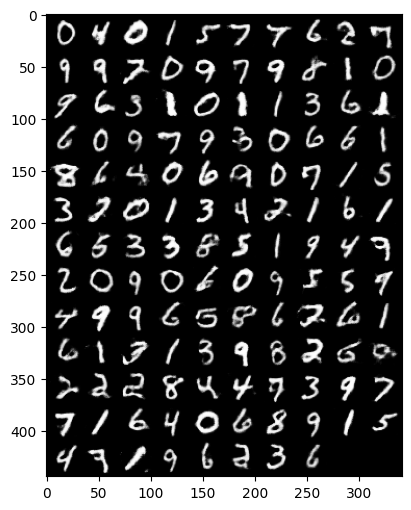

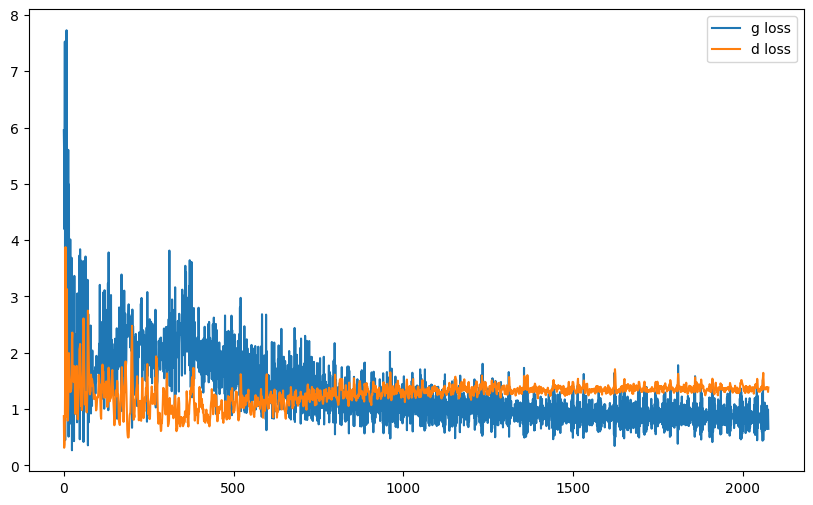

it: 2276; g_loss: 1.0678791999816895; d_loss: 1.3805606365203857; avg_real_score: 0.6173298358917236; avg_fake_score: 0.5803042650222778: : 400it [06:42,  1.00it/s]   

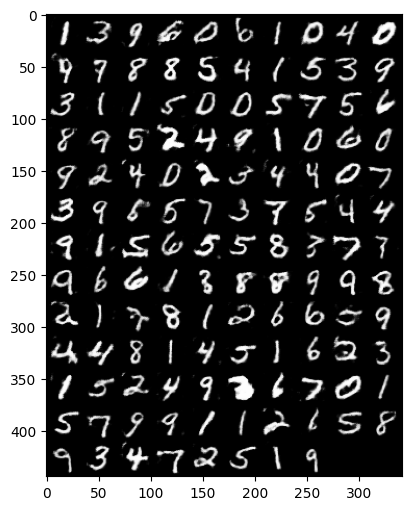

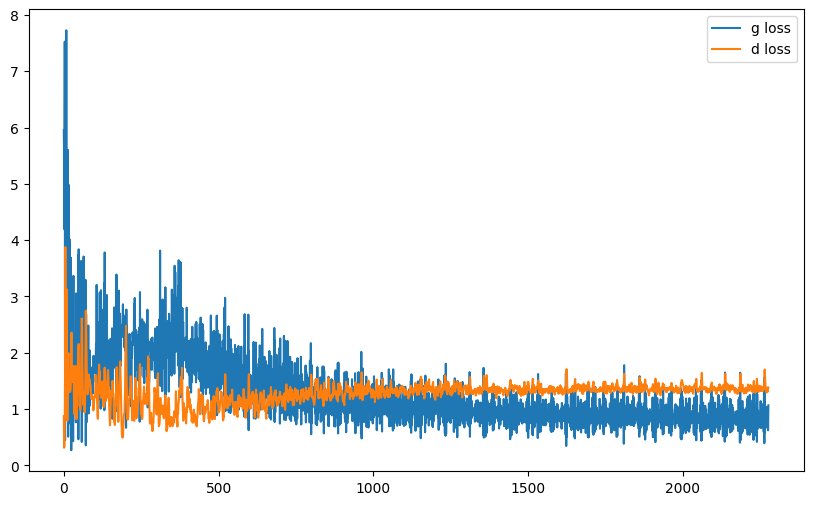

it: 2344; g_loss: 0.9269728660583496; d_loss: 1.3162448406219482; avg_real_score: 0.5246319770812988; avg_fake_score: 0.46782630681991577: : 469it [07:50,  1.00s/it] 


In [65]:
nb_epochs = 5

g_losses = []
d_losses = []

j = 0

for epoch in range(nb_epochs):

    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, labels = batch
        im = im.to(device)


        y = F.one_hot(labels).float().to(device)

        cur_batch_size = im.shape[0]

        ######### CODE A REMPLIR ##############################################################
        z = sample_z(cur_batch_size,nz)            # 1. sample a z vector
        fake_im = netG(z,y)                        # 2. Generate a fake image
        yhat_real = netD(im,y)                     # 3. Classify real image with D        
        yhat_fake = netD(fake_im.detach(),y)       # 4. Classify fake image with D
        #######################################################################################


        ###
        ### Discriminator
        ###

        ######### CODE A REMPLIR ##############################################################
        # d_loss = d_loss_real + d_loss_fake
        d_loss = criterion(yhat_real, get_labels_one(cur_batch_size)) + criterion(yhat_fake, get_labels_zero(cur_batch_size))
        #######################################################################################
        
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###

        ######### CODE A REMPLIR ##############################################################
        g_loss = criterion(netD(fake_im,y), get_labels_one(cur_batch_size))
        #######################################################################################

        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()

        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")

        if i % display_freq == 0:
            labels = torch.arange(0, 10).expand(size=(10, 10)).flatten().to(device)
            y = F.one_hot(labels).float().to(device)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=10)
            pil_grid = to_pil(grid)

            plt.imshow(pil_grid)
            plt.show()


            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1


## 4.2 Testing
Visualization of the impact of z on generation. All digits in the same column have the same noise vector z.

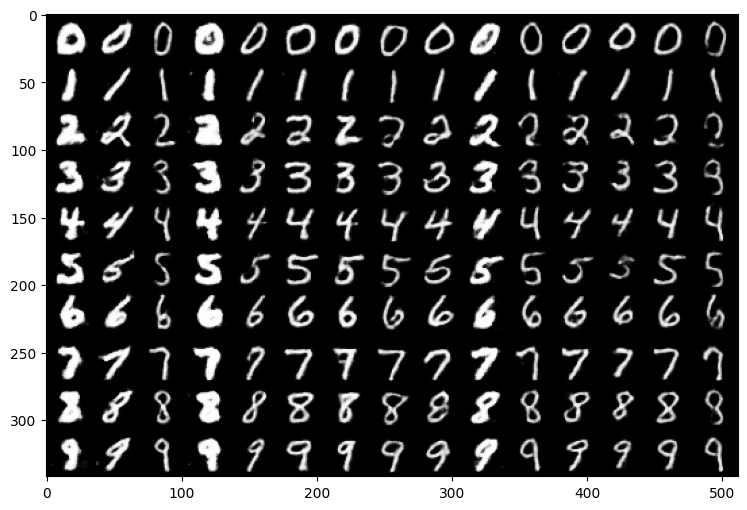

In [66]:
n_ex = 15
n_classes = 10

z = sample_z(n_ex, nz).repeat(n_classes, 1) #.expand(10, nz)

netG.eval()

labels = torch.arange(n_classes).unsqueeze(0).reshape(-1, 1).repeat(1, n_ex).flatten().to(device)

ys = F.one_hot(labels).float()
fake_ims = netG(z, ys)

un_norm= renorm(fake_ims) # for visualization
grid = torchvision.utils.make_grid(un_norm, nrow=n_ex)
pil_grid = to_pil(grid)

plt.imshow(pil_grid)
plt.show()
